This is a notebook that solves the uses the inifinite bus modelling of a synchronous machine, and approximates the solution using a physics-informed neural network.

Initially, the neural network and the synchronous machine equations are defined. 


Training the model with PINN
Epoch 2000, Loss: 0.004282448440790176
Epoch 4000, Loss: 0.003137049963697791
Epoch 6000, Loss: 0.0016973953461274505
Epoch 8000, Loss: 0.0013078859774395823
Epoch 10000, Loss: 0.0009186150855384767
Training the model without PINN
Epoch 2000, Loss: 0.006063189823180437
Epoch 4000, Loss: 0.003320901421830058
Epoch 6000, Loss: 0.0017476395005360246
Epoch 8000, Loss: 0.0011912911431863904
Epoch 10000, Loss: 0.0008053779602050781


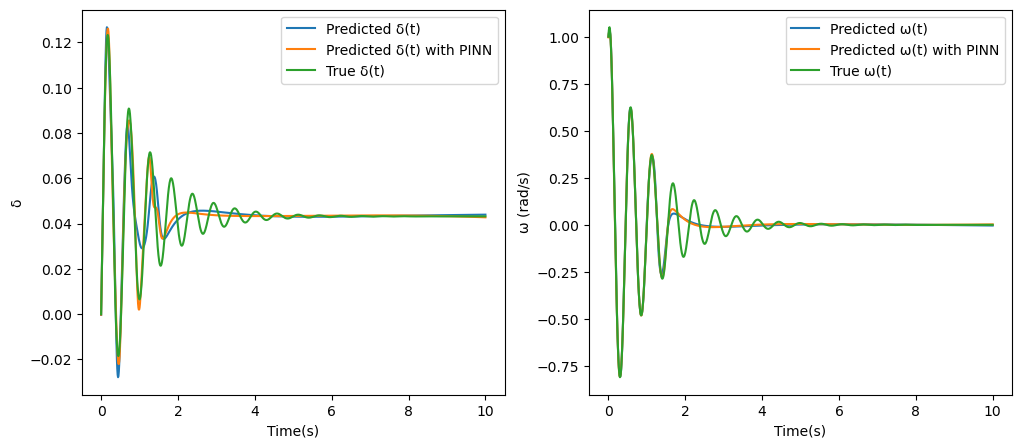

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Neural network architecture for the PINN
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Synchronous machine equations
def synchronous_machine_equations(t, x, E_q_dash, omega_B, H, P_m, X_d_dash, D, Vs, theta_vs, omega_s0):
    theta, omega = x
    #if theta is tensor then use torch.sin else use np.sin 
    if isinstance(theta, torch.Tensor):
        P_e = (E_q_dash * Vs / X_d_dash) * torch.sin(theta - theta_vs)
    else:
        P_e = (E_q_dash * Vs / X_d_dash) * np.sin(theta - theta_vs)
    
    
    dtheta_dt = omega
    domega_dt = (omega_B / (2 * H)) * (P_m - P_e - D * omega)
    
    return dtheta_dt, domega_dt

def set_time(duration, points):
    # set the time span and evaluation points
    t_span = (0, duration)
    t_eval = np.linspace(0, duration, points)
    return t_span, t_eval

def solve_ode(t_span, t_eval, E_q_dash, omega_B, H, P_m, X_d_dash, D, Vs, theta_vs, omega_s0, x0):
    # Solve the ODE using scipy
    solution = solve_ivp(synchronous_machine_equations, t_span, x0, args=(E_q_dash, omega_B, H, P_m, X_d_dash, D, Vs, theta_vs, omega_s0), t_eval=t_eval)
    
    return t_eval, solution.y


# Loss function that combines the ODE loss and the points loss based on the pinn_flag
# If flag is true, the loss function includes the ODE loss, otherwise only the points loss is considered    
def loss_function(pinn_flag, model, t, E_q_dash, omega_B, H, P_m, X_d_dash, D, Vs, theta_vs, omega_s0, x_true):
    # convert to tensor for autograd
    x_true = torch.tensor(x_true, dtype=torch.float32).T
    # Forward pass of the neural network
    x_pred = model(t)
    theta_pred = x_pred[:, 0:1]
    omega_pred = x_pred[:, 1:2]

    dtheta_dt_pred, domega_dt_pred = synchronous_machine_equations(
        t, [x_true[:, 0:1], x_true[:, 1:2]],
        E_q_dash, omega_B, H, P_m, X_d_dash, D, Vs, theta_vs, omega_s0
    )

    # Compute gradients of the predictions with respect to t using autograd
    dtheta_dt = torch.autograd.grad(theta_pred, t, grad_outputs=torch.ones_like(theta_pred), create_graph=True)[0]
    domega_dt = torch.autograd.grad(omega_pred, t, grad_outputs=torch.ones_like(omega_pred), create_graph=True)[0]

    # Loss function
    criterion = nn.MSELoss()
    # ODE residuals
    ode_loss = criterion(dtheta_dt, dtheta_dt_pred) + criterion(domega_dt, domega_dt_pred)
    
    # Points loss
    points_loss = criterion(x_pred, x_true)

    # Initial condition loss
    ic_loss = torch.mean((x_pred[0, :] - x_true[0,:])**2)
    weight_for_pinn_loss = 1e-3 if pinn_flag else 0.0

    return ode_loss*weight_for_pinn_loss + points_loss*(1-weight_for_pinn_loss) + ic_loss

# Training the PINN
def train_pinn(pinn_flag = True):
    # Initial conditions
    theta_0 = 0.0
    omega_0 = 1.0
    x0 = [theta_0, omega_0]
    
    # Parameters
    E_q_dash = 1.0
    omega_B = 2 * np.pi * 60


    H = 23.64
    P_m = 0.71
    X_d_dash = 0.0608
    D = 0.2364
    Vs = 1.0
    theta_vs = 0.0
    omega_s0 = 1.0

    t_span, t_eval = set_time(10, 1000)

    # Solve the ODE
    t, x = solve_ode(t_span, t_eval, E_q_dash, omega_B, H, P_m, X_d_dash, D, Vs, theta_vs, omega_s0, x0)

    # Time points
    t = torch.tensor(t, dtype=torch.float32).reshape(-1, 1) 
    t.requires_grad = True

    # Model
    model = PINN(input_dim=1, hidden_dim=64, output_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    log_output = []
    # Training loop
    print('Training the model', 'with PINN' if pinn_flag else 'without PINN')
    for epoch in range(10000):
        model.train()
        optimizer.zero_grad()
        loss = loss_function(pinn_flag, model, t, E_q_dash, omega_B, H, P_m, X_d_dash, D, Vs, theta_vs, omega_s0 , x)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 2000 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
            model.eval()
            with torch.no_grad():
                x_pred = model(t)
                log_output.append((x_pred, epoch+1))
    # Predict the trajectory
    with torch.no_grad():
        x_pred = model(t)
    
    theta_pred = x_pred[:, 0].numpy()
    omega_pred = x_pred[:, 1].numpy()

    return t.detach().numpy(), theta_pred, omega_pred, x, log_output

# Train the model and plot the results
t, theta_pred_pinn, omega_pred_pinn, x, log_output_pinn = train_pinn(pinn_flag=True)
t, theta_pred, omega_pred, x, log_output = train_pinn(pinn_flag=False)




plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, theta_pred, label='Predicted δ(t)')
plt.plot(t, theta_pred_pinn, label='Predicted δ(t) with PINN')
plt.plot(t, x[0], label='True δ(t)')
plt.xlabel('Time(s)')
plt.ylabel('δ')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, omega_pred, label='Predicted ω(t)')
plt.plot(t, omega_pred_pinn, label='Predicted ω(t) with PINN')
plt.plot(t, x[1], label='True ω(t)')
plt.xlabel('Time(s)')
plt.ylabel('ω (rad/s)')
plt.legend()

plt.show()


# solve it also 



Plot the results, where you can observe the accelaration in learning the trajectory

C:\Users\Giannis\AppData\Local\Temp\ipykernel_48036\1042477309.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


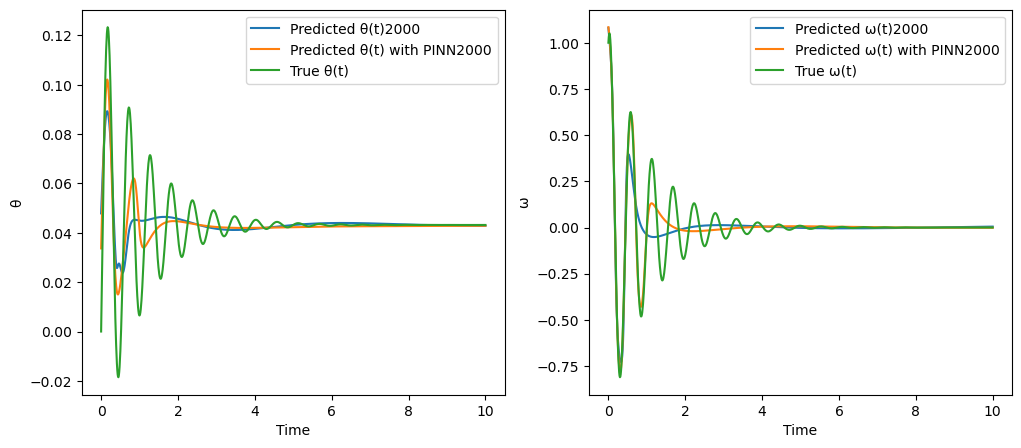

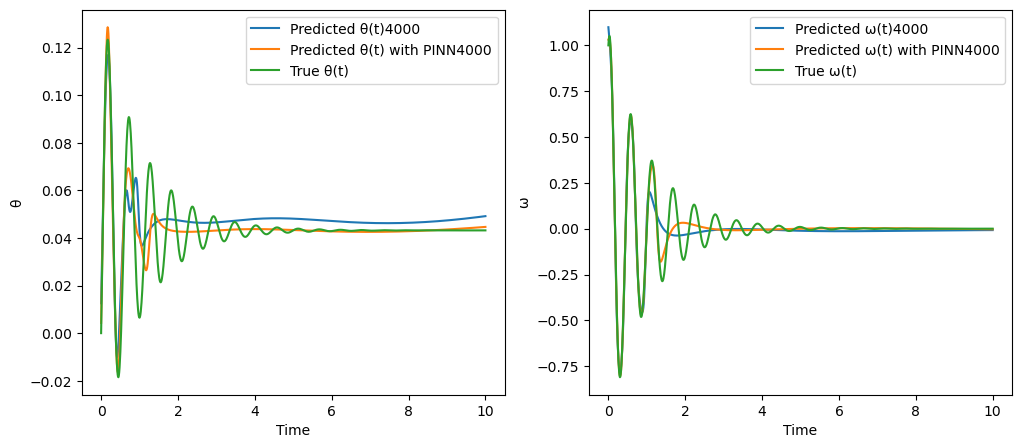

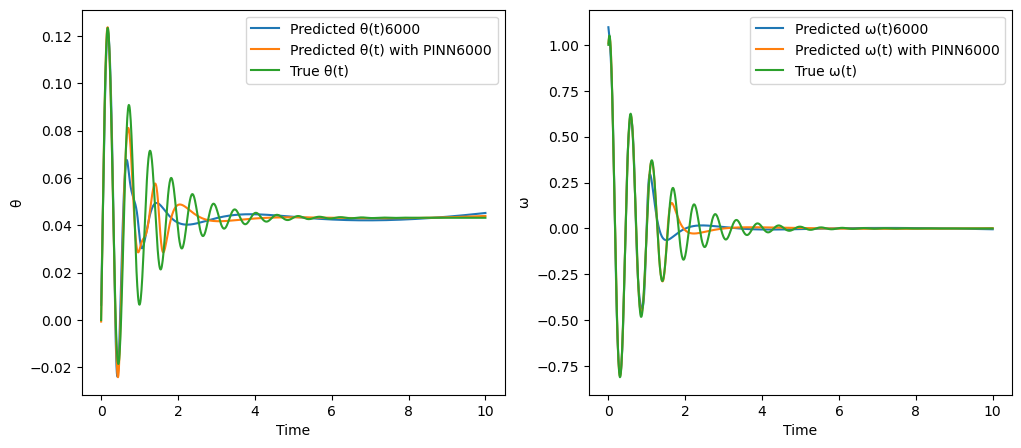

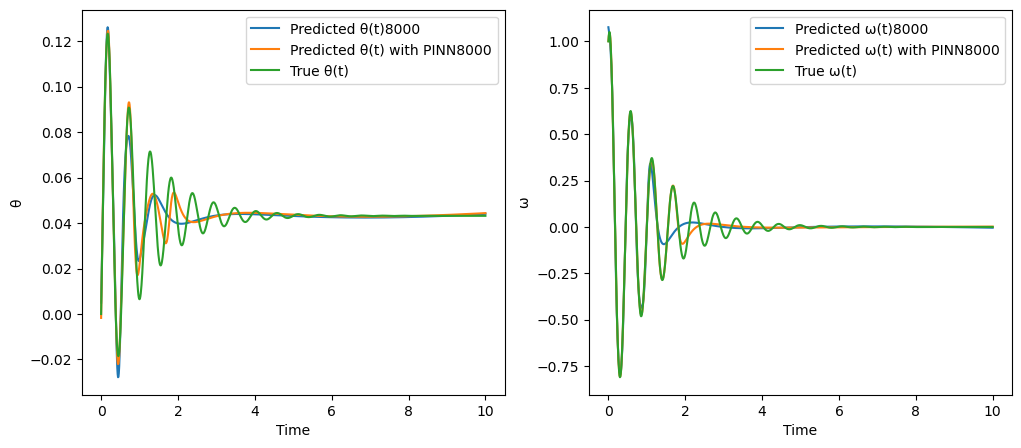

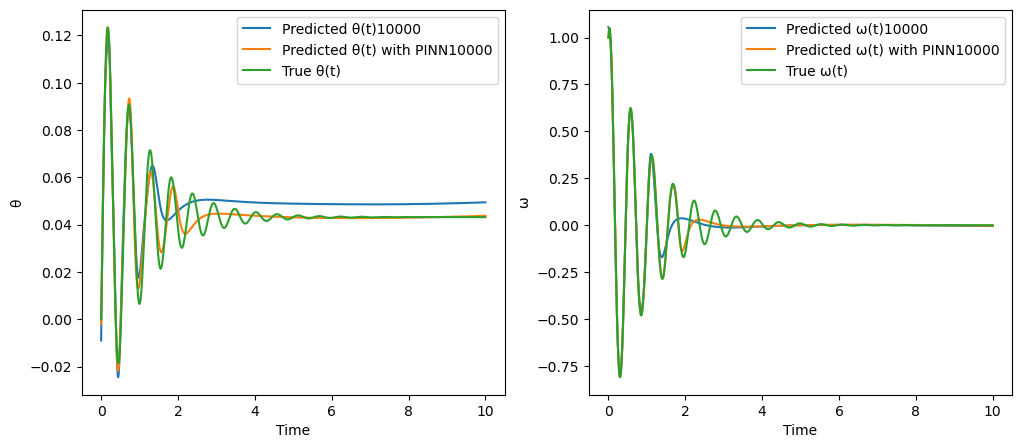

In [56]:
for i in range(len(log_output)):
    epoch = log_output[i][1]
    x_pred = log_output[i][0]
    theta_pred = x_pred[:, 0].numpy()
    omega_pred = x_pred[:, 1].numpy()
    x_pred_pinn = log_output_pinn[i][0]
    theta_pred_pinn = x_pred_pinn[:, 0].numpy()
    omega_pred_pinn = x_pred_pinn[:, 1].numpy()
    plt.figure(figsize=(12, 5))
    plt.title(f'Epoch {epoch}')
    
    plt.subplot(1, 2, 1)
    plt.plot(t, theta_pred, label='Predicted θ(t)'+str(epoch))
    plt.plot(t, theta_pred_pinn, label='Predicted θ(t) with PINN'+str(epoch))
    plt.plot(t, x[0], label='True θ(t)')
    plt.xlabel('Time')
    plt.ylabel('θ')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t, omega_pred, label='Predicted ω(t)'+str(epoch))
    plt.plot(t, omega_pred_pinn, label='Predicted ω(t) with PINN'+str(epoch))
    plt.plot(t, x[1], label='True ω(t)')
    plt.xlabel('Time')
    plt.ylabel('ω')
    plt.legend()
    plt.show()

